# Unsupervised Learning: Clustering & Member Segmentation

**Goal**: Discover natural groupings of Knight Hacks members based on their engagement and demographic patterns. We use PCA, t-SNE, K-Means, Hierarchical Clustering, and DBSCAN to identify distinct member personas *without* using the paid dues label.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

In [2]:
# Load Processed Data
df = pd.read_csv('../data/knight_hacks_dues_processed.csv')
print(f"Shape: {df.shape}")

# Drop the target variable entirely for unsupervised analysis
X_raw = df.drop('y_paid_dues', axis=1, errors='ignore')

Shape: (838, 36)


## 1. Preprocessing
Clustering requires numerical input and scaled data.

In [3]:
# Encode Categoricals
X_encoded = X_raw.copy()
cat_cols = X_encoded.select_dtypes(include=['object']).columns
print("Categorical columns:", cat_cols)

for col in cat_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

# Scale Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Convert back to DF for convenience
X_scaled_df = pd.DataFrame(X_scaled, columns=X_encoded.columns)

Categorical columns: Index(['class', 'school_grouped', 'major_grouped'], dtype='object')


## 2. Determine Optimal Clusters (K-Means)
Using Elbow Method and Silhouette Score.

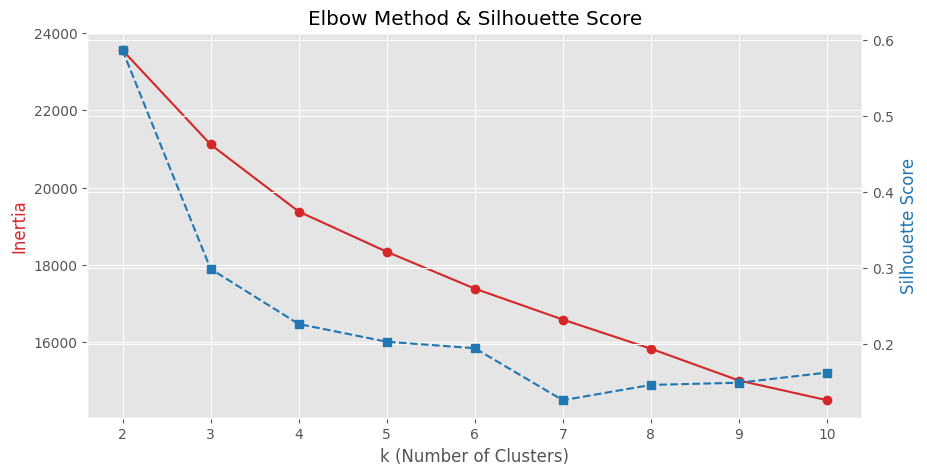

In [4]:
inertia = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_xlabel('k (Number of Clusters)')
ax1.set_ylabel('Inertia', color='tab:red')
ax1.plot(K, inertia, 'o-', color='tab:red', label='Inertia')

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='tab:blue')
ax2.plot(K, silhouette_scores, 's--', color='tab:blue', label='Silhouette')

plt.title('Elbow Method & Silhouette Score')
plt.show()

In [ ]:
# Fit K-Means with chosen k (e.g., 4)
k_final = 4
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add Cluster ID to original dataframe for interpretation
df['cluster_id'] = clusters

## 3. Visualizing Clusters
Using PCA and t-SNE to see the separation of our discovered clusters.

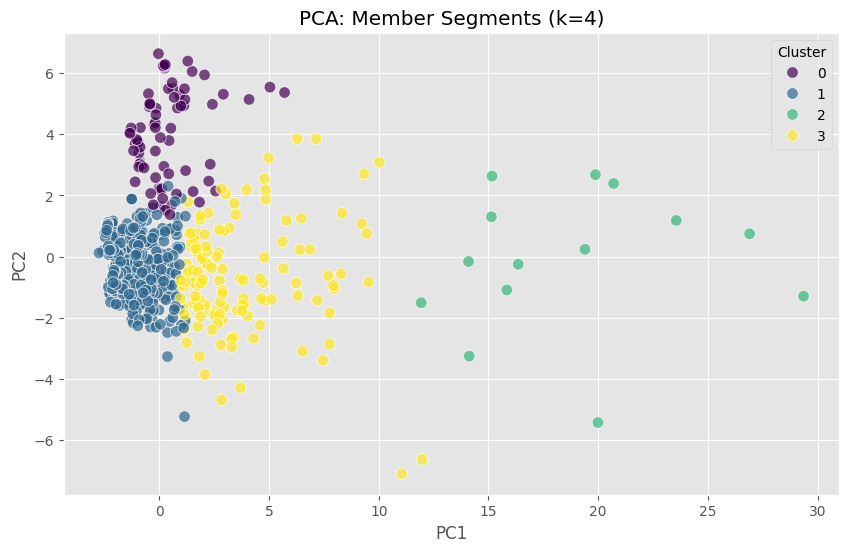

In [ ]:
# PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['cluster_id'], palette='viridis', s=70, alpha=0.7)
plt.title(f'PCA: Member Segments (k={k_final})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.show()

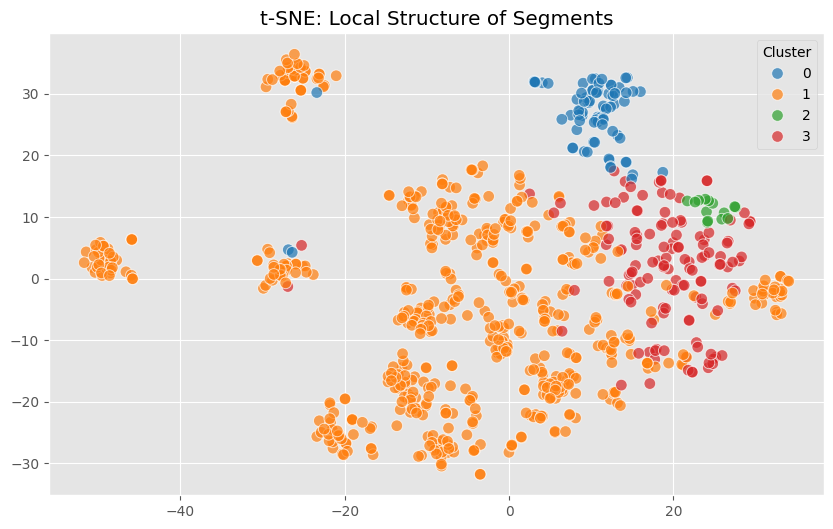

In [ ]:
# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df['cluster_id'], palette='tab10', s=70, alpha=0.7)
plt.title('t-SNE: Local Structure of Segments')
plt.legend(title='Cluster')
plt.show()

## 4. Hierarchical Clustering Dendrogram
To see how these clusters relate hierarchically.

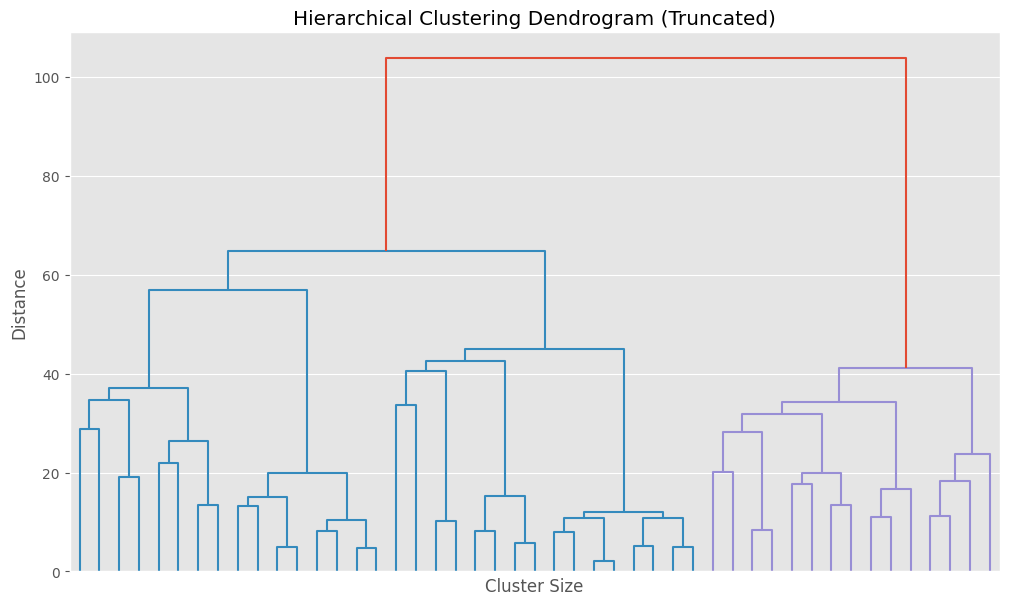

In [8]:
linked = linkage(X_scaled, 'ward')

plt.figure(figsize=(12, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False, no_labels=True, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

## 5. Cluster Interpretation & Profiling
What defines each group? We look at the mean values of key features.

            engagement_breadth  tech_score  social_score  is_sponsor_hunter  \
cluster_id                                                                    
0                     1.582278    2.075949      0.139241           0.000000   
1                     0.529316    0.180782      0.167752           0.060261   
2                     7.500000    8.785714      4.214286           0.000000   
3                     3.282443    1.885496      1.328244           0.000000   

            is_discord_active  events_attended_year  member_days_since_join  
cluster_id                                                                   
0                    0.544304              2.481013              302.670886  
1                    0.706840              0.558632              167.017915  
2                    1.000000             22.357143              295.214286  
3                    0.923664              5.374046              195.190840  


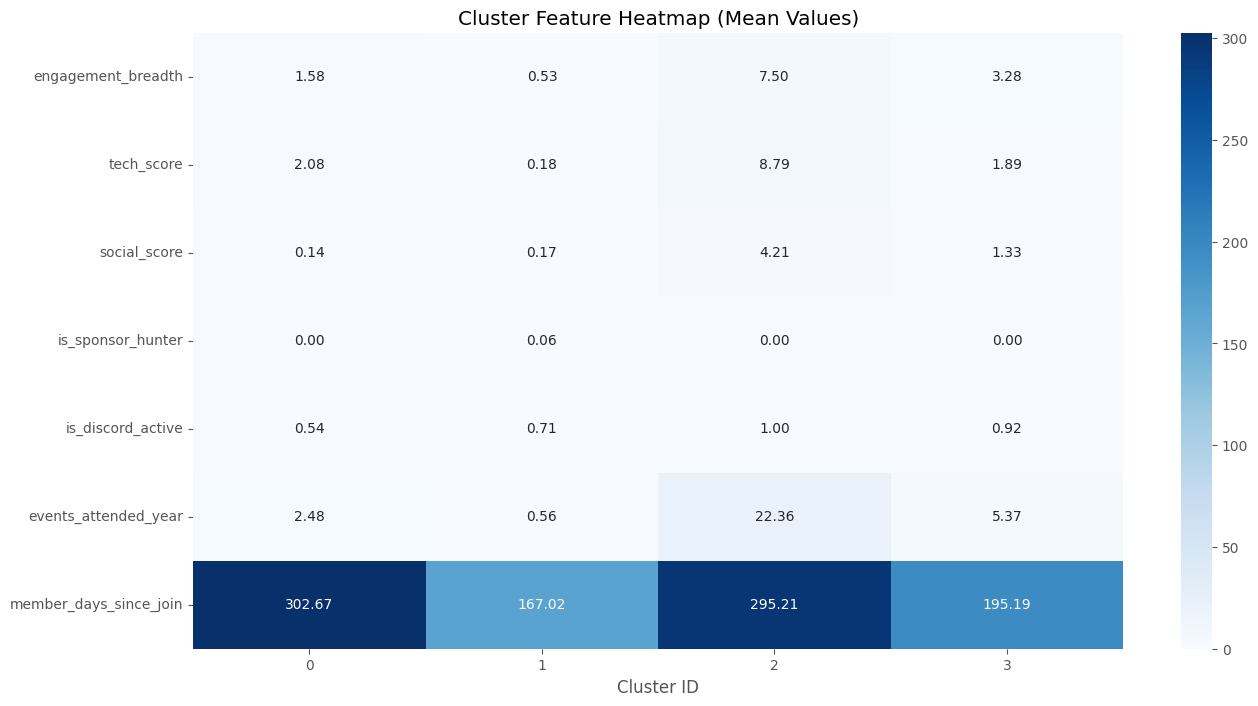

In [9]:
profile_cols = [
    'engagement_breadth', 'tech_score', 'social_score', 'is_sponsor_hunter', 
    'is_discord_active', 'events_attended_year', 'member_days_since_join'
]

# Calculate mean for each cluster
cluster_means = df.groupby('cluster_id')[profile_cols].mean()
print(cluster_means)

# Visualize Profiles
plt.figure(figsize=(15, 8))
sns.heatmap(cluster_means.T, annot=True, cmap='Blues', fmt='.2f')
plt.title('Cluster Feature Heatmap (Mean Values)')
plt.xlabel('Cluster ID')
plt.show()

In [10]:
for i in range(k_final):
    print(f"\n--- Cluster {i} Summary ---")
    print(df[df['cluster_id'] == i][profile_cols].describe().loc['mean'])
    print("Dominant Major:", df[df['cluster_id'] == i]['major_grouped'].mode()[0])


--- Cluster 0 Summary ---
engagement_breadth          1.582278
tech_score                  2.075949
social_score                0.139241
is_sponsor_hunter           0.000000
is_discord_active           0.544304
events_attended_year        2.481013
member_days_since_join    302.670886
Name: mean, dtype: float64
Dominant Major: Computer Science

--- Cluster 1 Summary ---
engagement_breadth          0.529316
tech_score                  0.180782
social_score                0.167752
is_sponsor_hunter           0.060261
is_discord_active           0.706840
events_attended_year        0.558632
member_days_since_join    167.017915
Name: mean, dtype: float64
Dominant Major: Computer Science

--- Cluster 2 Summary ---
engagement_breadth          7.500000
tech_score                  8.785714
social_score                4.214286
is_sponsor_hunter           0.000000
is_discord_active           1.000000
events_attended_year       22.357143
member_days_since_join    295.214286
Name: mean, dtype: flo